# Colorectal histology - Final Project
Author: Gabriel TRUONG

## Exploratory Data Analysis

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Sequential
from tensorflow_datasets.image_classification import colorectal_histology
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from utils import plot_accuracy_loss


import datetime
SEED = 42

2022-12-17 23:56:17.378721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 23:56:17.477010: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-17 23:56:17.480695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-17 23:56:17.480704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

### Data Collection

In [2]:
(train_ds,train_label),(val_ds, val_label)= tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split=["train[:80%]", "train[80%:]"],
    batch_size=-1,
    as_supervised=True,
))

print(type(train_ds), train_ds.shape)

2022-12-17 23:56:22.986068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-17 23:56:22.986086: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-17 23:56:22.986097: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lapbeer): /proc/driver/nvidia/version does not exist
2022-12-17 23:56:22.986275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'numpy.ndarray'> (4000, 150, 150, 3)


### Visualisation of images

In [3]:
class_names = colorectal_histology._CLASS_NAMES
class_names

('tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty')

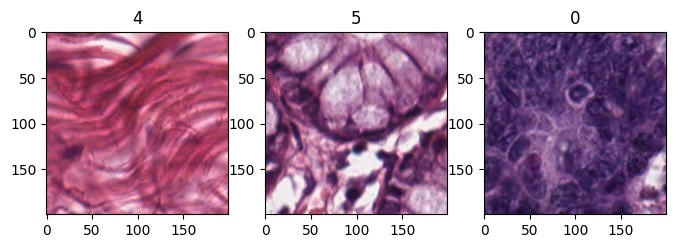

In [4]:
fig, ax = plt.subplots(1,3,figsize=(8,8))
size=(200,200)

img = [Image.fromarray(train_ds[i], 'RGB').resize(size) for i in range(4)]

ax[0].imshow(img[0],cmap = 'gray')
ax[0].set_title(train_label[0])
ax[1].imshow(img[1],cmap = 'gray')
ax[1].set_title(train_label[1])
ax[2].imshow(img[3],cmap = 'gray')
ax[2].set_title(train_label[3])
plt.show()

Text(0.5, 1.0, 'Number of occurences of a val label')

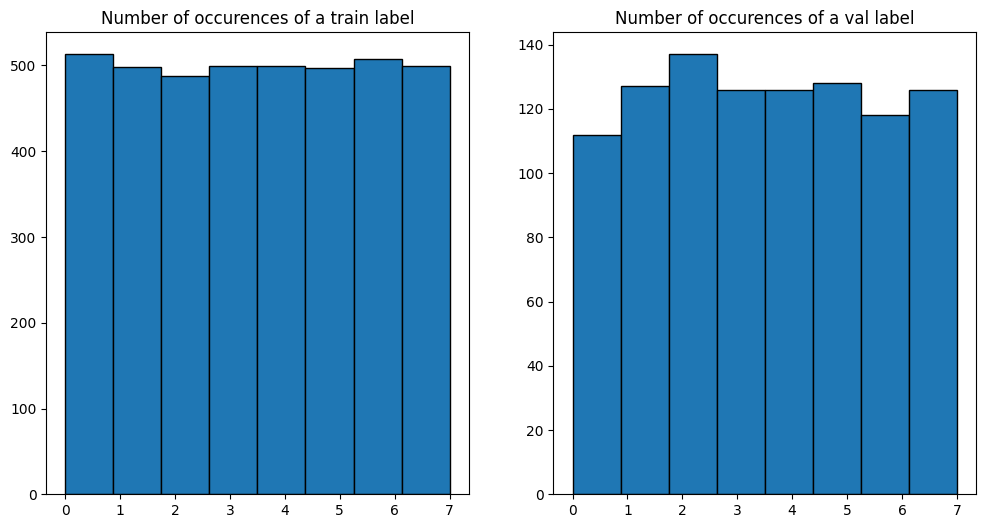

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(train_label, bins=len(np.unique(train_label)), edgecolor="black")
ax1.set_title("Number of occurences of a train label")

ax2.hist(val_label, bins=len(np.unique(val_label)), edgecolor="black")
ax2.set_title("Number of occurences of a val label")

We can see that the training set is quite balanced. The validation set is not as balanced but it enables to see how the model perform on a slightly different distribution.

In [6]:
tf.keras.utils.set_random_seed(SEED)

In [8]:
%tensorboard --logdir logs/fit


UsageError: Line magic function `%tensorboard` not found.


### Baseline model

This model is simple Artificial Neural Network. The architecture comes from a lab on the fashion MNIST dataset. Since we are dealing with images, we add a flatten layer to suit the architecture. Without this preprocessing layer, not all the layers will be fully connected to the input.

In [9]:
logs = {}

baseline_model = Sequential([
    layers.Flatten(input_shape=[150, 150,3]),
    layers.Dense(300,activation="relu"),
    layers.Dense(100,activation="relu"),
    layers.Dense(8,activation="softmax")
])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 300)               20250300  
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
Total params: 20,281,208
Trainable params: 20,281,208
Non-trainable params: 0
_________________________________________________________________


In [10]:
baseline_model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")

For this baseline model, we only add a tensorboard callback to monitor the training.

In [11]:
log_dir = "logs/colorectal_project_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
baseline_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [12]:
logs["Baseline"] = baseline_model.fit(train_ds,train_label,
                            epochs=10,callbacks=baseline_cb,
                            validation_data=(val_ds,val_label))

Epoch 1/10
125/125 [==============================] - 16s 127ms/step - loss: 3682.9690 - accuracy: 0.2280 - val_loss: 1375.5201 - val_accuracy: 0.2790
Epoch 2/10
125/125 [==============================] - 11s 92ms/step - loss: 814.0372 - accuracy: 0.3573 - val_loss: 788.7551 - val_accuracy: 0.3400
Epoch 3/10
125/125 [==============================] - 12s 93ms/step - loss: 515.1431 - accuracy: 0.3810 - val_loss: 195.0034 - val_accuracy: 0.4090
Epoch 4/10
125/125 [==============================] - 12s 93ms/step - loss: 496.1483 - accuracy: 0.3817 - val_loss: 326.1843 - val_accuracy: 0.3790
Epoch 5/10
125/125 [==============================] - 12s 93ms/step - loss: 205.4439 - accuracy: 0.4543 - val_loss: 184.9726 - val_accuracy: 0.2930
Epoch 6/10
125/125 [==============================] - 12s 93ms/step - loss: 233.8676 - accuracy: 0.4142 - val_loss: 343.8136 - val_accuracy: 0.3420
Epoch 7/10
125/125 [==============================] - 12s 94ms/step - loss: 140.8293 - accuracy: 0.4545 - val

In [13]:
print(baseline_model.evaluate(val_ds,val_label))
baseline_predictions=baseline_model.predict(val_ds)

32/32 [==============================] - 0s 13ms/step - loss: 89.4960 - accuracy: 0.2470
[89.49595642089844, 0.24699999392032623]
32/32 [==============================] - 0s 13ms/step


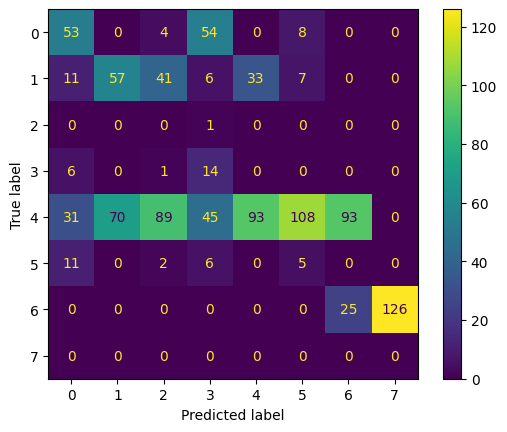

In [14]:
baseline_cm=confusion_matrix(np.argmax(baseline_predictions,axis=1),val_label)
ConfusionMatrixDisplay(baseline_cm).plot()

/home/lapbeer/Documents/epf/5A/pred_modeling/final_project/colorectal_project/utils.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


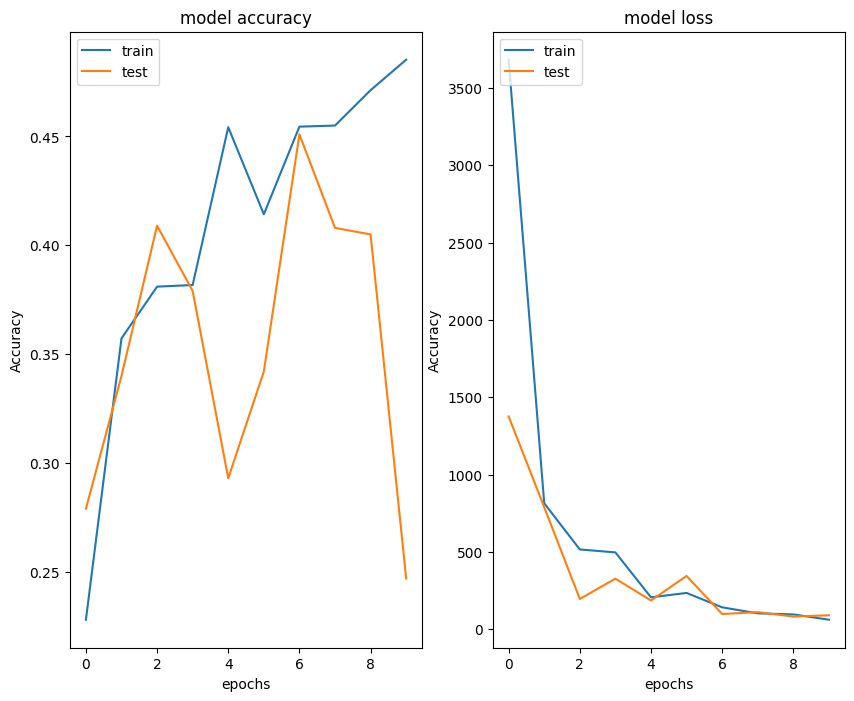

In [16]:
plot_accuracy_loss(logs['Baseline'])

For our baseline model, we get a low accuracy on both the training and the validation set. 
Also we can see with the confusion matrix that the model only predict on few labels and miss many of them. We need to add complexity so that the model also predicts on the other labels. Also we need to be careful of overfitting.

### Convolutional Neural Network

With this model, we want to add complexity by adding more suitable layers such as Convolution2D and MaxPool2D. This model 

In [17]:
basic_cnn = Sequential([
            layers.Convolution2D(32, (3 ,3), activation='relu',input_shape=(150,150,3)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(20, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(12, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(8, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(activation='relu', units=128),
            layers.Dense(activation='softmax', units=8),
])
basic_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 20)        5780      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 20)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 12)        2172      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 12)      

In [18]:
log_dir = "logs/colorectal_project_CNN" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
basic_CNN_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [19]:
basic_cnn.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
history_cnn=basic_cnn.fit(train_ds,train_label,
                            epochs=30,
                            validation_data=(val_ds,val_label),callbacks=basic_CNN_cb)

Epoch 1/30
125/125 [==============================] - 14s 112ms/step - loss: 2.3242 - accuracy: 0.2420 - val_loss: 1.7222 - val_accuracy: 0.3060
Epoch 2/30
125/125 [==============================] - 14s 109ms/step - loss: 1.6779 - accuracy: 0.3417 - val_loss: 1.6060 - val_accuracy: 0.3460
Epoch 3/30
125/125 [==============================] - 14s 110ms/step - loss: 1.5513 - accuracy: 0.3850 - val_loss: 1.7131 - val_accuracy: 0.2800
Epoch 4/30
125/125 [==============================] - 14s 116ms/step - loss: 1.4567 - accuracy: 0.4083 - val_loss: 1.3614 - val_accuracy: 0.4340
Epoch 5/30
125/125 [==============================] - 14s 114ms/step - loss: 1.2529 - accuracy: 0.4893 - val_loss: 1.2066 - val_accuracy: 0.4970
Epoch 6/30
125/125 [==============================] - 14s 112ms/step - loss: 1.0835 - accuracy: 0.5585 - val_loss: 1.0567 - val_accuracy: 0.5650
Epoch 7/30
125/125 [==============================] - 14s 111ms/step - loss: 0.9424 - accuracy: 0.5965 - val_loss: 0.9658 - val_ac

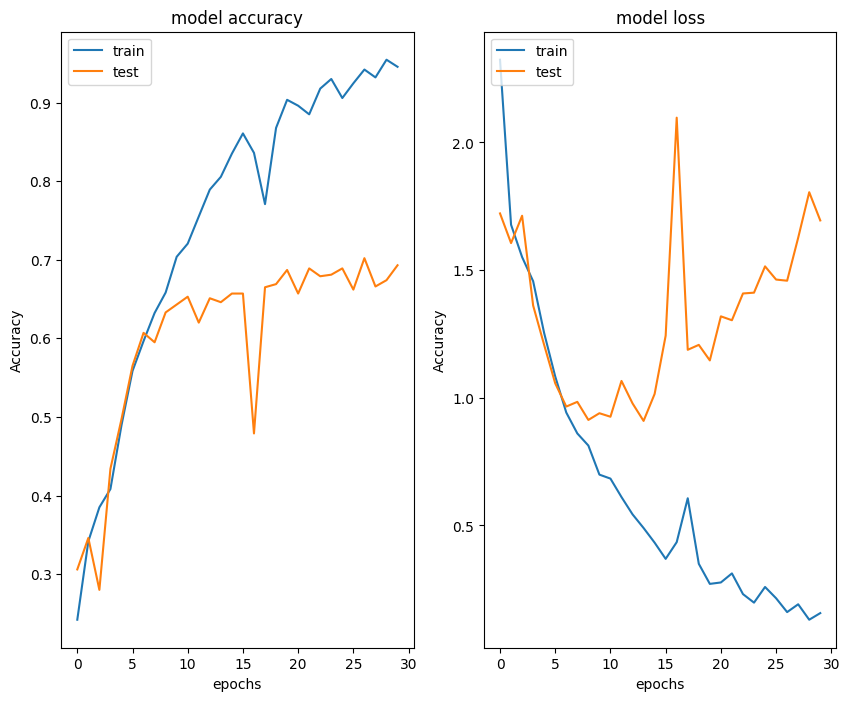

In [21]:
plot_accuracy_loss(history_cnn)

On the graph shown ,we can clearly see at 10th epochs, the validation loss stopped decreasing while the training loss kept decreasing. Underfitting is quite obvious here, we will confirm this intuition with confusion matrix.

In [22]:
cnn_prediction=basic_cnn.predict(val_ds)

32/32 [==============================] - 1s 38ms/step


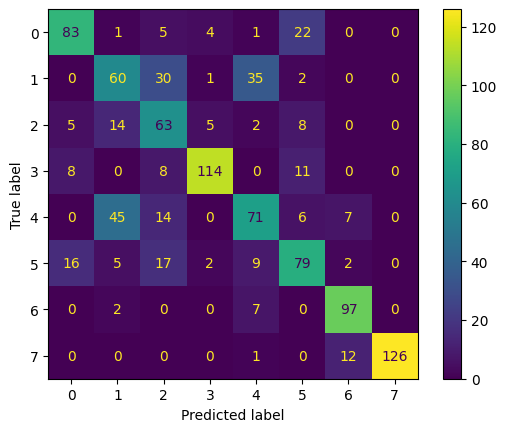

In [23]:
moredepth_cm=confusion_matrix(np.argmax(cnn_prediction,axis=1),val_label)
ConfusionMatrixDisplay(moredepth_cm).plot()

From the plots, we can clearly see that the model performs very well on the training set but not on the validation set. We reached a good generalization and now to improve the performance on the validation set we need to reduce the overfitting. To do so, we could either use a Dropout layer or add data augmentation to add data. 
We will try the 2nd option and see if it works.

### Reduce overfitting

#### Data Augmentation

In this part we will add Data Augmentation layers to add different point of view for the model. We expect the model to be less overfitted since it will train on more data. 

In [24]:
augmented_cnn = Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),
            layers.Convolution2D(64, (3 ,3), activation='relu',input_shape=(150,150,3)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(20, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(12, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(8, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(activation='relu', units=128),
            layers.Dense(activation='softmax', units=8),
])


In [25]:
log_dir = "logs/colorectal_project_augmented" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
augmented_CNN_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [26]:
augmented_cnn.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
history_augmented=augmented_cnn.fit(train_ds,train_label,
                            epochs=30,
                            validation_data=(val_ds,val_label),callbacks=augmented_CNN_cb)

Epoch 1/30


125/125 [==============================] - 29s 216ms/step - loss: 1.9576 - accuracy: 0.2700 - val_loss: 1.6659 - val_accuracy: 0.3400
Epoch 2/30
125/125 [==============================] - 26s 206ms/step - loss: 1.4808 - accuracy: 0.4087 - val_loss: 1.2749 - val_accuracy: 0.4780
Epoch 3/30
125/125 [==============================] - 29s 231ms/step - loss: 1.2899 - accuracy: 0.4580 - val_loss: 1.2945 - val_accuracy: 0.4390
Epoch 4/30
125/125 [==============================] - 30s 236ms/step - loss: 1.0646 - accuracy: 0.5548 - val_loss: 0.9932 - val_accuracy: 0.5870
Epoch 5/30
125/125 [==============================] - 30s 236ms/step - loss: 0.9499 - accuracy: 0.6097 - val_loss: 0.8907 - val_accuracy: 0.6340
Epoch 6/30
125/125 [==============================] - 29s 234ms/step - loss: 0.9425 - accuracy: 0.6215 - val_loss: 0.8439 - val_accuracy: 0.6670
Epoch 7/30
125/125 [==============================] - 28s 225ms/step - loss: 0.8464 - accuracy: 0.6645 - val_loss: 0.7885 - val_accuracy: 0.7

/home/lapbeer/Documents/epf/5A/pred_modeling/final_project/colorectal_project/utils.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


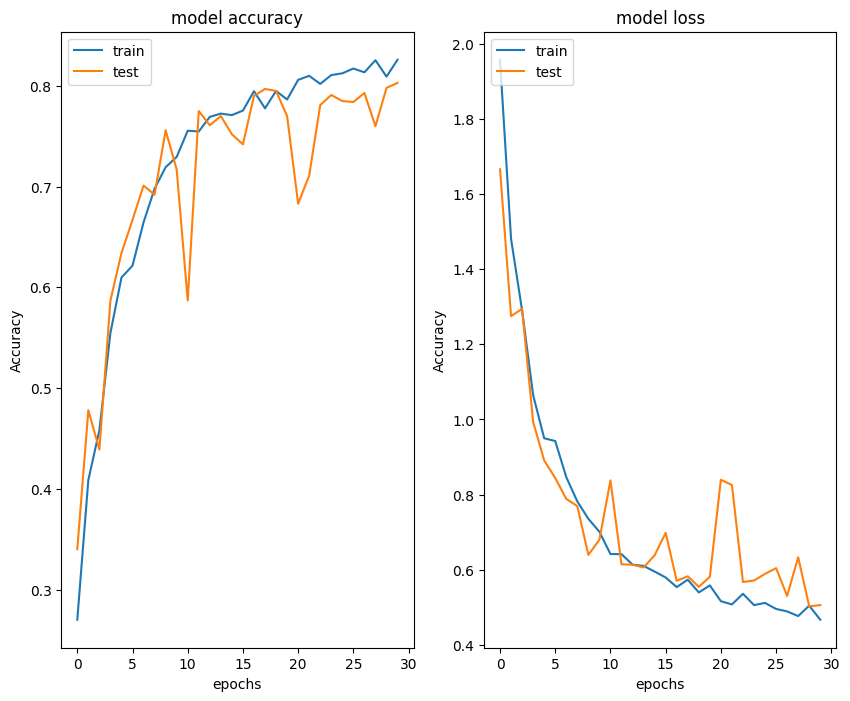

In [28]:
plot_accuracy_loss(history_augmented)

On the graph shown ,we can clearly see at 10th epochs, the validation loss stopped decreasing while the training loss kept decreasing. Underfitting is quite obvious here, we will confirm this intuition with confusion matrix.

In [ ]:
cnn_prediction=basic_cnn.predict(val_ds)

32/32 [==============================] - 1s 38ms/step


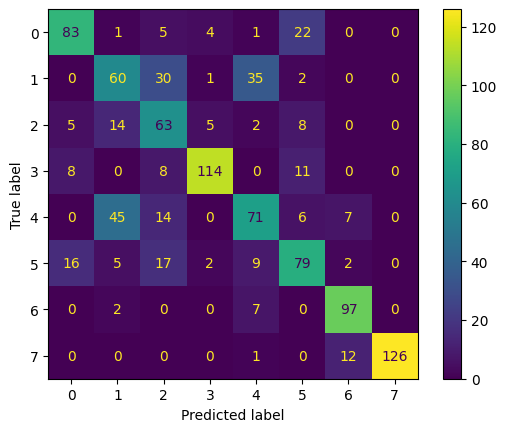

In [ ]:
moredepth_cm=confusion_matrix(np.argmax(cnn_prediction,axis=1),val_label)
ConfusionMatrixDisplay(moredepth_cm).plot()

#### Add complexity and early stoppings

In the previous step, we use data augmentation to reduce overfitting and it worked very well. Now we will add complexity and a early-stopping callback to prevent overfitting again. Also it sould save us some computational time. If this step doesn't work, we will stick to the already very accurate model.

In [ ]:
wider_cnn = Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),
            layers.Convolution2D(128, (3 ,3), activation='relu',input_shape=(150,150,3)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(64, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(32, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(8, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(activation='relu', units=128),
            layers.Dense(activation='softmax', units=8),
])


In [27]:
log_dir = "logs/colorectal_project_augmented" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
augmented_CNN_cb = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3),
tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]


In [ ]:
wider_cnn.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
history_augmented=wider_cnn.fit(train_ds,train_label,
                            epochs=30,
                            validation_data=(val_ds,val_label),callbacks=augmented_CNN_cb)

Epoch 1/30


125/125 [==============================] - 29s 216ms/step - loss: 1.9576 - accuracy: 0.2700 - val_loss: 1.6659 - val_accuracy: 0.3400
Epoch 2/30
125/125 [==============================] - 26s 206ms/step - loss: 1.4808 - accuracy: 0.4087 - val_loss: 1.2749 - val_accuracy: 0.4780
Epoch 3/30
125/125 [==============================] - 29s 231ms/step - loss: 1.2899 - accuracy: 0.4580 - val_loss: 1.2945 - val_accuracy: 0.4390
Epoch 4/30
125/125 [==============================] - 30s 236ms/step - loss: 1.0646 - accuracy: 0.5548 - val_loss: 0.9932 - val_accuracy: 0.5870
Epoch 5/30
125/125 [==============================] - 30s 236ms/step - loss: 0.9499 - accuracy: 0.6097 - val_loss: 0.8907 - val_accuracy: 0.6340
Epoch 6/30
125/125 [==============================] - 29s 234ms/step - loss: 0.9425 - accuracy: 0.6215 - val_loss: 0.8439 - val_accuracy: 0.6670
Epoch 7/30
125/125 [==============================] - 28s 225ms/step - loss: 0.8464 - accuracy: 0.6645 - val_loss: 0.7885 - val_accuracy: 0.7

### Archive

more_depth_model = Sequential([
    layers.Flatten(input_shape=[150, 150,3]),
    layers.Dense(300,activation="relu"),
    layers.Dense(100,activation="relu"),
    layers.Dense(32,activation="relu"),
    layers.Dense(8,activation="softmax")
])
more_depth_model.summary()
more_depth_model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
For this baseline model, we only add a tensorboard callback to monitor the training.
log_dir = "logs/colorectal_project_depth_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
more_depth_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

logs["more_depth"] = more_depth_model.fit(train_ds,train_label,
                            epochs=10,callbacks=more_depth_cb,
                            validation_data=(val_ds,val_label),batch_size=16)
plot_monitoring(logs['more_depth'])
print(more_depth_model.evaluate(val_ds,val_label))
more_depth_predictions=more_depth_model.predict(val_ds)
moredepth_cm=confusion_matrix(np.argmax(more_depth_predictions,axis=1),val_label)
ConfusionMatrixDisplay(moredepth_cm).plot()